###**Criar um classificador de chamados aplicando técnicas de PLN**
---

A **DinDinAgora** tem um canal de atendimento via chat e precisa classificar os assuntos dos atendimentos para melhorar as tratativas dos chamados dos clientes. O canal recebe textos abertos dos clientes relatando o problema e/ou dúvida e depois é direcionado para algum uma área especialista no assunto para uma melhor tratativa.​

Crie um modelo classificador de assuntos aplicando técnicas de PLN, que consiga classificar através de um texto o assunto conforme disponível na base de dados [1] para treinamento e validação do modelo seu modelo.​

O modelo precisar atingir um score na **métrica F1 Score superior a 75%**. Utilize o dataset [1] para treinar e testar o modelo, separe o dataset em duas amostras (75% para treinamento e 25% para teste com o randon_state igual a 42).​

Fique à vontade para testar e explorar as técnicas de pré-processamento, abordagens de NLP, algoritmos e bibliotecas, mas explique e justifique as suas decisões durante o desenvolvimento.​

**Composição da nota:​**

**50%** - Demonstrações das aplicações das técnicas de PLN (regras, pré-processamentos, tratamentos, variedade de modelos aplicados, organização do pipeline, etc.)​

**50%** - Baseado na performance (score) obtida com a amostra de teste no pipeline do modelo campeão (validar com  a Métrica F1 Score). **Separar o pipeline completo do modelo campeão conforme template.​**

**[1] = ​https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv**

Obs.: Para a métrica F1 Score, usar o parâmetro average = 'weighted'.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [2]:
import pandas as pd

df = pd.read_csv("tickets_reclamacoes_classificados.csv",sep=';')


In [112]:
df.head()

,id_reclamacao,data_abertura,categoria,descricao_reclamacao
0,3229299,2019-05-01T12:00:00-05:00,Hipotecas / Empréstimos,"Bom dia, meu nome é xxxx xxxx e agradeço se vo..."
1,3199379,2019-04-02T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...
2,3233499,2019-05-06T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,O cartão Chase foi relatado em xx/xx/2019. No ...
3,3180294,2019-03-14T12:00:00-05:00,Cartão de crédito / Cartão pré-pago,"Em xx/xx/2018, enquanto tentava reservar um ti..."
4,3224980,2019-04-27T12:00:00-05:00,Serviços de conta bancária,"Meu neto me dê cheque por {$ 1600,00} Eu depos..."


##### Vamos verificar os tipos de categorias existentes

In [113]:
df.categoria.unique()

array(['Hipotecas / Empréstimos', 'Cartão de crédito / Cartão pré-pago',
       'Serviços de conta bancária', 'Outros',
       'Roubo / Relatório de disputa'], dtype=object)

##### Vamos verificar quantas reclamações tem em cada categoria

In [114]:
df.groupby("categoria")["descricao_reclamacao"].count()

categoria
Cartão de crédito / Cartão pré-pago    5006
Hipotecas / Empréstimos                3850
Outros                                 2233
Roubo / Relatório de disputa           4822
Serviços de conta bancária             5161
Name: descricao_reclamacao, dtype: int64

<AxesSubplot: ylabel='categoria'>

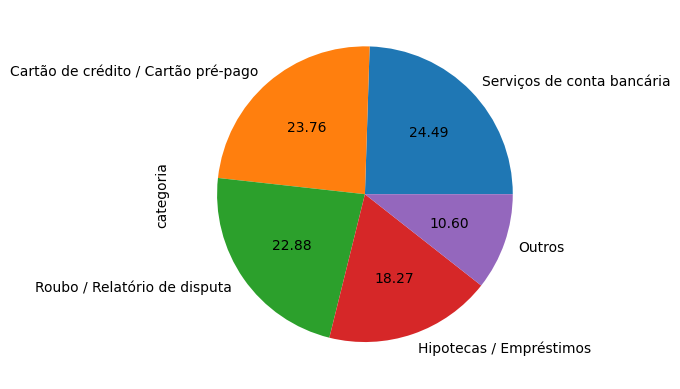

In [115]:
df['categoria'].value_counts().plot.pie(autopct='%.2f')

##### Os valores estão equilibrados de certa forma, se não conseguirmos bom resultado, provavelmente iremos equilibrar a base

##### Vamos verificar se tem algum dado em branco

In [116]:
df.descricao_reclamacao.isnull().sum()

0

In [117]:
df.descricao_reclamacao.isna().sum()

0

In [3]:
import nltk
nltk.download('rslp')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
!pip install tensorflow
!pip install keras
!pip install spacy
!python -m spacy download pt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import unidecode
from nltk.stem.rslp import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
import spacy
from sklearn.neural_network import MLPClassifier



[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


     ---------------------------------------- 13.0/13.0 MB 8.4 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use
the full pipeline package name 'pt_core_news_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


##### Sem fazer muitas alterações, vamos tentar rodar alguns modelos estatíticos

In [4]:
def tfidvectorizer(ngram,stop_words):
    vect = TfidfVectorizer(ngram_range=ngram,stop_words=stop_words)
    vect.fit(df_train.descricao_reclamacao)
    return vect
def vectorizer(ngram,stop_words):
    vect = CountVectorizer(ngram_range=ngram,stop_words=stop_words)
    vect.fit(df_train.descricao_reclamacao)
    return vect

def rodar_modelo(vect,model):

    X_train = vect.transform(df_train.descricao_reclamacao)
    y_train = df_train["categoria"]

    model.fit(X_train, y_train)

    X_test = vect.transform(df_test.descricao_reclamacao)
    y_prediction = model.predict(X_test)

    # Verificar a accuracia
    y_test = df_test["categoria"]
    accuracy = accuracy_score(y_prediction, y_test)
    print(accuracy)
    return model


In [120]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]
df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = vectorizer((1,1),[])
vecbi  = vectorizer((2,2),[])
vectri = vectorizer((3,3),[])

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))
print("Bigrama e DecisionTreeClassifier:")
rodar_modelo(vecbi,DecisionTreeClassifier(random_state=42))
print("Trigrama e DecisionTreeClassifier:")
rodar_modelo(vectri,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))
print("Bigrama e LogisticRegression:")
rodar_modelo(vecbi,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))
print("Trigrama e LogisticRegression:")
rodar_modelo(vectri,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))
print("Bigrama e RandomForestClassifier:")
rodar_modelo(vecbi,RandomForestClassifier(random_state=42))
print("Trigrama e RandomForestClassifier:")
rodar_modelo(vectri,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())
print("Bigrama e MultinomialNB:")
rodar_modelo(vecbi,MultinomialNB())
print("Trigrama e MultinomialNB:")
rodar_modelo(vectri,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))
print("Bigrama e GradientBoostingClassifier:")
rodar_modelo(vecbi,GradientBoostingClassifier(random_state=42))
print("Trigrama e GradientBoostingClassifier:")
rodar_modelo(vectri,GradientBoostingClassifier(random_state=42))



Unigrama e DecisionTreeClassifier:
0.7276006074411542
Bigrama e DecisionTreeClassifier:
0.6499620349278664
Trigrama e DecisionTreeClassifier:
0.5727031131359149
Unigrama e LogisticRegression:
0.8986332574031891
Bigrama e LogisticRegression:
0.8528853454821564
Trigrama e LogisticRegression:
0.7697418375094913
Unigrama e RandomForestClassifier:
0.8086560364464692
Bigrama e RandomForestClassifier:
0.7902429764616553
Trigrama e RandomForestClassifier:
0.6903948367501899
Unigrama e MultinomialNB:
0.8058086560364465
Bigrama e MultinomialNB:
0.7710706150341685
Trigrama e MultinomialNB:
0.7526575550493546
Unigrama e GradientBoostingClassifier:
0.8709187547456341
Bigrama e GradientBoostingClassifier:
0.7972665148063781
Trigrama e GradientBoostingClassifier:
0.6909643128321944


GradientBoostingClassifier(random_state=42)

##### Conseguimos resultados bons, mas queremos um modelo que tenha uma taxa de acerto ainda maior, então vamos tentar tratar os dados.

In [5]:
# iniciada uma váriavel que irá guardar as stop words
stopwords = nltk.corpus.stopwords.words('portuguese')

##### Vamos criar a função que transforma as categorias em número.

In [6]:
def transformar_categorias():
    global dataset
    label_enconder = LabelEncoder()
    labels_categorias = label_enconder.fit_transform(dataset.categoria)
    dataset.categoria = labels_categorias

##### Função que irá remover todas as sensuras dos dados.

In [7]:
def remover_sensura():
    global dataset
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.replace('x', '', regex=True)

##### Função que irá deixar o texto todo em minusculo.

In [8]:
def strlower():
    global dataset
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.str.lower()

##### Função que irá retirar a categoria outros.

In [9]:
def retirar_outros():
    global dataset
    dataset = dataset[dataset["categoria"] != "Outros"]

##### Função que irá retirar a acentuação.

In [10]:
def retirar_acentuacao():
    global dataset
    dataset.descricao_reclamacao = [unidecode.unidecode(texto) for texto in dataset.descricao_reclamacao]

##### Função que irá lematizar o texto.

In [11]:
def lematize():
    global dataset
    nlp = spacy.load('pt_core_news_sm')
    dataset.descricao_reclamacao = [' '.join(token.lemma_ for token in nlp(linha)) for linha in dataset.descricao_reclamacao]

##### Função que irá stemmer o texto.

In [12]:
def stemmer():
    global dataset
    rslp = RSLPStemmer()
    def stemmer(line):
        return ' '.join([rslp.stem(token) for token in line])

    dataset.descricao_reclamacao = dataset.descricao_reclamacao.apply(word_tokenize)
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.apply(stemmer)

##### Função que irá retirar todos os caracteres especiais.

In [13]:
def apenas_texto():
    global dataset
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.replace('[^a-zA-Z ]', '', regex=True)

##### Função que ira apagar todos os espaços extras no texto.

In [14]:
def retirar_espacos():
    dataset.descricao_reclamacao = dataset.descricao_reclamacao.replace(' [^a-zA-Z]', '', regex=True)

##### Primeiramente vamos tentar rodar os modelos com todos os tratamentos, e utilizando somente o unigram, pois além de ser mais perfomatico, foi o que teve maior acuracia.


In [131]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
retirar_espacos()
lematize()
#stemmer()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

dataset

,categoria,descricao_reclamacao
0,1,bom dia meu nome e e agradeco se voce puder eu...
1,0,atualizei meu cartao eme ser informar por o ag...
2,0,ele cartao chase ser relatar emno entanto o pe...
3,0,emenquanto tentar reservar um ticket eu depare...
4,3,meu neto eu de cheque por eu depositar o em o ...
...,...,...
21064,2,emarquiveir um disputa em o meu empresa de car...
21066,3,meu marido falecer o chase bank controlar o ch...
21067,0,depois de ser um cliente de cartao de persegui...
21068,2,em o quarta feiraliguei para o chas meu proved...


In [132]:
vecuni = vectorizer((1,1),stopwords)

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e DecisionTreeClassifier:
0.7819532908704884
Unigrama e LogisticRegression:
0.9176220806794055
Unigrama e RandomForestClassifier:
0.8596602972399151
Unigrama e MultinomialNB:
0.8558386411889597
Unigrama e GradientBoostingClassifier:
0.8949044585987261


GradientBoostingClassifier(random_state=42)

##### Mantendo os tratamentos anteriores, vamos tentar com o tfid.

In [133]:
vecuni = tfidvectorizer((1,1),stopwords)

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e DecisionTreeClassifier:
0.802547770700637
Unigrama e LogisticRegression:
0.9254777070063694
Unigrama e RandomForestClassifier:
0.8634819532908705
Unigrama e MultinomialNB:
0.8016985138004247
Unigrama e GradientBoostingClassifier:
0.9012738853503185


GradientBoostingClassifier(random_state=42)

##### Vamos tentar retirar o lematize usando o tfid, pois percebemos que teve um score melhor.


In [134]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
retirar_espacos()
#lematize()


df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

dataset

,categoria,descricao_reclamacao
0,1,bom dia meu nome e e agradeco se voce puder me...
1,0,atualizei meu cartao eme fui informado pelo ag...
2,0,o cartao chase foi relatado emno entanto o ped...
3,0,emenquanto tentava reservar um ticket me depar...
4,3,meu neto me de cheque por eu depositei o na mi...
...,...,...
21064,2,emarquivei uma disputa na minha empresa de car...
21066,3,meu marido faleceu o chase bank controlou o ch...
21067,0,depois de ser um cliente de cartao de persegui...
21068,2,na quarta feiraliguei para o chas meu provedor...


In [135]:
vecuni = tfidvectorizer((1,1),stopwords)

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e DecisionTreeClassifier:
0.7868365180467092
Unigrama e LogisticRegression:
0.9222929936305733
Unigrama e RandomForestClassifier:
0.8636942675159236
Unigrama e MultinomialNB:
0.8082802547770701
Unigrama e GradientBoostingClassifier:
0.8902335456475584


GradientBoostingClassifier(random_state=42)

##### Por algum motivo retirar os espaços em brancos caiu bastante o acerto, então vamos manter.

In [136]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

dataset

,categoria,descricao_reclamacao
0,1,bom dia meu nome e e agradeco se voce puder ...
1,0,atualizei meu cartao em e fui informado pel...
2,0,o cartao chase foi relatado em no entanto o p...
3,0,em enquanto tentava reservar um ticket me d...
4,3,meu neto me de cheque por eu depositei o na ...
...,...,...
21064,2,em arquivei uma disputa na minha empresa de c...
21066,3,meu marido faleceu o chase bank controlou o ch...
21067,0,depois de ser um cliente de cartao de persegui...
21068,2,na quarta feira liguei para o chas meu proved...


In [137]:
vecuni = tfidvectorizer((1,1),stopwords)

print("Unigrama e DecisionTreeClassifier:")
rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

#Multinomial não tem o parâmetro random_state
print("Unigrama e MultinomialNB:")
rodar_modelo(vecuni,MultinomialNB())

#Multinomial não tem o parâmetro random_state
print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e DecisionTreeClassifier:
0.7942675159235669
Unigrama e LogisticRegression:
0.9233545647558387
Unigrama e RandomForestClassifier:
0.8692144373673036
Unigrama e MultinomialNB:
0.8146496815286625
Unigrama e GradientBoostingClassifier:
0.8902335456475584


GradientBoostingClassifier(random_state=42)

##### Nos testes anteriores retiramos a categoria outros, vamos mante-la, e veremos se será relevante retirar ele do treino e criar uma forma de categorizar outros de acordo qual a chance dele não ser de nenhuma categoria.

In [138]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

dataset

,categoria,descricao_reclamacao
0,1,bom dia meu nome e e agradeco se voce puder ...
1,0,atualizei meu cartao em e fui informado pel...
2,0,o cartao chase foi relatado em no entanto o p...
3,0,em enquanto tentava reservar um ticket me d...
4,4,meu neto me de cheque por eu depositei o na ...
...,...,...
21067,0,depois de ser um cliente de cartao de persegui...
21068,3,na quarta feira liguei para o chas meu proved...
21069,3,nao estou familiarizado com o xxxx pay e nao e...
21070,2,eu tive credito impecavel por anos eu tive ca...


In [139]:
vecuni = tfidvectorizer((1,1),stopwords)

# Como esse modelo não teve um bom score durante todo o desenvolvimento, vou retira-lo dos testes
#print("Unigrama e DecisionTreeClassifier:")
#rodar_modelo(vecuni,DecisionTreeClassifier(random_state=42))

print("Unigrama e LogisticRegression:")
rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))

print("Unigrama e RandomForestClassifier:")
rodar_modelo(vecuni,RandomForestClassifier(random_state=42))

# Como esse modelo não teve um bom score durante todo o desenvolvimento, vou retira-lo dos testes
#print("Unigrama e MultinomialNB:")
#rodar_modelo(vecuni,MultinomialNB())

print("Unigrama e GradientBoostingClassifier:")
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42))

Unigrama e LogisticRegression:
0.9060364464692483
Unigrama e RandomForestClassifier:
0.8158694001518603
Unigrama e GradientBoostingClassifier:
0.8792710706150342


GradientBoostingClassifier(random_state=42)

##### Vamos tentar algumas variações do modelo LogisticRegression Obs: vamos manter a categoria "Outros", pois não abaixou muito o acerto.

In [140]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1),stopwords)

print("Unigrama e LogisticRegression:")

for solver in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'] :
    print("solver: "+solver)
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver=solver, max_iter=1000))
for multi_class in ['auto', 'ovr', 'multinomial'] :
    print("multi_class: "+multi_class)
    rodar_modelo(vecuni,LogisticRegression(random_state=42,multi_class=multi_class, max_iter=1000))
for penalty in ['l1','l2'] :
    print("penalty: "+penalty+" solver: liblinear")
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='liblinear',penalty=penalty, max_iter=1000))
for penalty in ['l2'] :
    print("penalty: "+penalty+" solver: newton-cg")
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='newton-cg',penalty=penalty, max_iter=1000))
for penalty in ['l2'] :
    print("penalty: "+penalty+" solver: lbfgs")
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='lbfgs',penalty=penalty, max_iter=1000))
for penalty in ['l2'] :
    print("penalty: "+penalty+" solver: sag")
    rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='sag',penalty=penalty, max_iter=1000))
for penalty in ['l2','l1','elasticnet'] :
    print("penalty: "+penalty+" solver: saga")
    if('elasticnet' == penalty):
        rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='saga',penalty=penalty, max_iter=1000,l1_ratio=1))
    else:
        rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='saga',penalty=penalty, max_iter=1000))

Unigrama e LogisticRegression:
solver: liblinear
0.9062262718299164
solver: newton-cg
0.9060364464692483
solver: lbfgs
0.9060364464692483
solver: sag
0.9060364464692483
solver: saga
0.9060364464692483
multi_class: auto
0.9060364464692483
multi_class: ovr
0.9062262718299164
multi_class: multinomial
0.9060364464692483
penalty: l1 solver: liblinear
0.9126803340926348
penalty: l2 solver: liblinear
0.9062262718299164
penalty: l2 solver: newton-cg
0.9060364464692483
penalty: l2 solver: lbfgs
0.9060364464692483
penalty: l2 solver: sag
0.9060364464692483
penalty: l2 solver: saga
0.9060364464692483
penalty: l1 solver: saga
0.912870159453303
penalty: elasticnet solver: saga
0.912870159453303


In [144]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1),stopwords)

rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='saga',penalty="l1",multi_class="multinomial"))

0.912870159453303


LogisticRegression(multi_class='multinomial', penalty='l1', random_state=42,
                   solver='saga')

##### A LogisticRegression teve um ótimo desempenho, mas como somos gananciosos vamos tentar melhores isso, vamos tentar melhorar o RandomForestClassifier.




In [15]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize_stemmer()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1),stopwords)

print("Unigrama e RandomForestClassifier:")

for criterion in ['gini','entropy','log_loss'] :
    print("criterion: "+criterion)
    rodar_modelo(vecuni,RandomForestClassifier(random_state=42,criterion=criterion))
for max_depth in [1,3,5,10,20,40,60,80,160,200,500,1000,5000] :
    print("max_depth: "+max_depth.__str__())
    rodar_modelo(vecuni,RandomForestClassifier(random_state=42,max_depth=max_depth))
for min_samples_split in [3,5,10,20,40,60,80,160,200,500,1000,5000] :
    print("min_samples_split: "+min_samples_split.__str__())
    rodar_modelo(vecuni,RandomForestClassifier(random_state=42,min_samples_split=min_samples_split))
for n_estimators in [1,3,5,10,20,40,60,80,160,200,300,400,500] :
    print("n_estimators: "+n_estimators.__str__())
    rodar_modelo(vecuni,RandomForestClassifier(random_state=42,n_estimators=n_estimators))

Unigrama e RandomForestClassifier:
criterion: gini
0.8158694001518603
criterion: entropy
0.8149202733485194
criterion: log_loss
0.8149202733485194
max_depth: 1
0.4029992406985573
max_depth: 3
0.5882687927107062
max_depth: 5
0.6623006833712984
max_depth: 10
0.7156416097190584
max_depth: 20
0.75
max_depth: 40
0.7866362946089598
max_depth: 60
0.8071374335611238
max_depth: 80
0.809415337889142
max_depth: 160
0.8181473044798785
max_depth: 200
0.8211845102505695
max_depth: 500
0.8158694001518603
max_depth: 1000
0.8158694001518603
max_depth: 5000
0.8158694001518603
min_samples_split: 3
0.8192862566438877
min_samples_split: 5
0.8164388762338648
min_samples_split: 10
0.8190964312832194
min_samples_split: 20
0.8198557327258922
min_samples_split: 40
0.8171981776765376
min_samples_split: 60
0.8177676537585421
min_samples_split: 80
0.812452543659833
min_samples_split: 160
0.8048595292331056
min_samples_split: 200
0.7985952923310554
min_samples_split: 500
0.7760060744115413
min_samples_split: 1000
0

##### Tentamos algumas variações do RandomForest, mas não obtivemos bons resultados. Nesse caso não vamos continuar com os testes.
##### Agora vamos fazer alguns testes com GradientBoostingClassifier

In [16]:
dataset = df.copy()[["categoria","descricao_reclamacao"]]

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1),stopwords)

print("n_estimators e GradientBoostingClassifier:")

for n_estimators in [10,50,100,200,250,300,500] :
    print("n_estimators: "+n_estimators.__str__())
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,n_estimators=n_estimators))

for criterion in ['friedman_mse','squared_error'] :
    print("criterion: "+criterion)
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,criterion=criterion))

for min_samples_leaf in [2,3,5,10,20,40] :
    print("min_samples_leaf: "+min_samples_leaf.__str__())
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,min_samples_leaf=min_samples_leaf))

for max_depth in [1,3,5,10,20,40,60] :
    print("max_depth: "+max_depth.__str__())
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,max_depth=max_depth))

for learning_rate in [0.2,0.3,0.4] :
    print("learning_rate: "+learning_rate.__str__())
    rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,learning_rate=learning_rate))

n_estimators e GradientBoostingClassifier:
n_estimators: 10
0.7984054669703873
n_estimators: 50
0.8619969627942293
n_estimators: 100
0.8792710706150342
n_estimators: 200
0.8859149582384207
n_estimators: 250
0.8874335611237661
n_estimators: 300
0.8895216400911162
n_estimators: 500
0.8908504176157934
criterion: friedman_mse
0.8792710706150342
criterion: squared_error


KeyboardInterrupt: 

In [17]:
rodar_modelo(vecuni,GradientBoostingClassifier(random_state=42,n_estimators=250,criterion="squared_error",min_samples_leaf=10,max_depth=5,learning_rate=0.3))

0.8933181473044799


GradientBoostingClassifier(criterion='squared_error', learning_rate=0.3,
                           max_depth=5, min_samples_leaf=10, n_estimators=250,
                           random_state=42)

##### Tentamos várias configurações diferentes, como o GradientBoostingClassifier é bem lento, por isso cancelamos no meio da execução, mesmo assim conseguimos encontrar a melhor combinação, mas ele não conseguiu ser o modelo campeão.

##### Por enquanto conseguimos uma acurácia de 0.9147684130599848, vamos tentar equilibrar a base usando o modelo campeão


In [18]:
dataset_use = df.copy()[["categoria","descricao_reclamacao"]]

dataset = pd.DataFrame()

dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Cartão de crédito / Cartão pré-pago"],replace=True,n_samples=5161,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Hipotecas / Empréstimos"],replace=True,n_samples=5161,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Outros"],replace=True,n_samples=5161,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Roubo / Relatório de disputa"],replace=True,n_samples=5161,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Serviços de conta bancária"],replace=True,n_samples=5161,random_state=42)])

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = tfidvectorizer((1,1),stopwords)

model = rodar_modelo(vecuni,LogisticRegression(random_state=42,solver='saga',penalty="l2",multi_class="multinomial"))


0.944513329200248


##### Conseguimos um ótimo resultado com essa alteração

### Confusion Matrix do melhor modelo

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

tfidf = TfidfVectorizer(ngram_range=(1,1),stop_words=stopwords)

vector_tfidf = tfidf.fit_transform(dataset.descricao_reclamacao)
X_train, X_test, y_train, y_test = train_test_split(
    vector_tfidf, dataset.categoria, test_size=0.25, random_state=42)

model.fit(X_train, y_train)
LR_acuracia_03 = model.score(X_test, y_test)

LG_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, LG_pred)
print(conf_matrix)

print(classification_report(y_test, LG_pred))

[[1214   13   16   48   17]
 [  14 1257   13   15   10]
 [   7   18 1227    9   12]
 [  34   28   15 1162   30]
 [  13   12    7   26 1235]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1308
           1       0.95      0.96      0.95      1309
           2       0.96      0.96      0.96      1273
           3       0.92      0.92      0.92      1269
           4       0.95      0.96      0.95      1293

    accuracy                           0.94      6452
   macro avg       0.94      0.94      0.94      6452
weighted avg       0.94      0.94      0.94      6452



### EXTRA
##### Vamos agora tentar algumas soluções em DeepLearn.
##### Vamos pegar uma pequena amostra, se não ficará muito pesado pra treinar.

In [23]:
dataset_use = df.copy()[["categoria","descricao_reclamacao"]]

dataset = pd.DataFrame()
numero_amostra = 250
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Cartão de crédito / Cartão pré-pago"],replace=True,n_samples=numero_amostra,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Hipotecas / Empréstimos"],replace=True,n_samples=numero_amostra,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Outros"],replace=True,n_samples=numero_amostra,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Roubo / Relatório de disputa"],replace=True,n_samples=numero_amostra,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Serviços de conta bancária"],replace=True,n_samples=numero_amostra,random_state=42)])

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize_stemmer()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)

vecuni = vectorizer((1,1),stopwords)

X_train = vecuni.transform(df_train.descricao_reclamacao)
y_train = df_train["categoria"]

X_train

<937x11357 sparse matrix of type '<class 'numpy.int64'>'
	with 79278 stored elements in Compressed Sparse Row format>

In [24]:
from tensorflow.keras.layers import LSTM,Embedding,SimpleRNN,Dense,GlobalAveragePooling1D,Dropout,Conv1D,MaxPooling1D,GlobalAveragePooling1D,SpatialDropout1D,Bidirectional,BatchNormalization
from tensorflow.keras import Sequential
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import math
import numpy as np
def verificar_accuracy():
    global X_test,y_test
    X_test = vecuni.transform(df_test.descricao_reclamacao)
    y_prediction = model.predict(X_test.toarray())
    y_prediction = [np.argmax(linha) for linha in y_prediction]

    # Verificar a accuracia
    y_test = df_test["categoria"]
    accuracy = accuracy_score(y_prediction, y_test)
    print(accuracy)

##### Vou ultizar uma network simples, vamos ver o que acontece.

In [25]:
model = Sequential()
model.add(Dense(128,input_dim=X_train.shape[1],activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(X_train.toarray(), to_categorical(y_train, num_classes=5) ,validation_split=0.2, epochs=500, batch_size=16,callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])
#model.summary()

Epoch 1/500
47/47 [==============================] - 2s 11ms/step - loss: 1.6063 - accuracy: 0.2457 - val_loss: 1.5570 - val_accuracy: 0.2553
Epoch 2/500
47/47 [==============================] - 0s 2ms/step - loss: 1.4658 - accuracy: 0.5981 - val_loss: 1.4234 - val_accuracy: 0.6330
Epoch 3/500
47/47 [==============================] - 0s 2ms/step - loss: 1.1997 - accuracy: 0.8772 - val_loss: 1.1938 - val_accuracy: 0.6809
Epoch 4/500
47/47 [==============================] - 0s 2ms/step - loss: 0.8604 - accuracy: 0.9346 - val_loss: 0.9580 - val_accuracy: 0.8085
Epoch 5/500
47/47 [==============================] - 0s 3ms/step - loss: 0.5712 - accuracy: 0.9800 - val_loss: 0.8096 - val_accuracy: 0.7819
Epoch 6/500
47/47 [==============================] - 0s 3ms/step - loss: 0.3666 - accuracy: 0.9960 - val_loss: 0.7141 - val_accuracy: 0.7713
Epoch 7/500
47/47 [==============================] - 0s 3ms/step - loss: 0.2414 - accuracy: 0.9973 - val_loss: 0.6481 - val_accuracy: 0.7819
Epoch 8/500


In [26]:
verificar_accuracy()

10/10 [==============================] - 0s 4ms/step
0.8338658146964856


##### Conseguimos de primeira um bom acerto, mas ainda não foi o suficiente para bater o modelo campeão.
##### Vamos tentar um modelo mais sofisticado, Com Embedding e LSTM.

In [27]:
model = Sequential()

model.add(Embedding(7000, 32 ,input_length = X_train.shape[1]))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(5,activation='softmax'))

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(X_train.toarray(), to_categorical(y_train, num_classes=5) ,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
24/24 [==============================] - 30s 1s/step - loss: 1.6113 - accuracy: 0.1909 - val_loss: 1.6086 - val_accuracy: 0.2234
Epoch 2/10
24/24 [==============================] - 26s 1s/step - loss: 1.6110 - accuracy: 0.1923 - val_loss: 1.6099 - val_accuracy: 0.1862
Epoch 3/10
24/24 [==============================] - 25s 1s/step - loss: 1.6095 - accuracy: 0.2043 - val_loss: 1.6085 - val_accuracy: 0.2234
Epoch 4/10
24/24 [==============================] - 25s 1s/step - loss: 1.6098 - accuracy: 0.1896 - val_loss: 1.6085 - val_accuracy: 0.2340
Epoch 5/10
24/24 [==============================] - 25s 1s/step - loss: 1.6094 - accuracy: 0.1963 - val_loss: 1.6087 - val_accuracy: 0.1862
Epoch 6/10
24/24 [==============================] - 25s 1s/step - loss: 1.6098 - accuracy: 0.1949 - val_loss: 1.6086 - val_accuracy: 0.2234
Epoch 7/10
24/24 [==============================] - 27s 1s/step - loss: 1.6095 - accuracy: 0.1896 - val_loss: 1.6086 - val_accuracy: 0.2340
Epoch 8/10
24/24 [==

In [28]:
verificar_accuracy()

10/10 [==============================] - 5s 407ms/step
0.19169329073482427


##### Ao fazer os testes, verificamos que tanto o Layer LSTM e o Embedding são muito lentos, e não temos poder computacional ou tempo para testar, nesse caso vamos continuar testando variações simples de neurônios. ( testamos vários outros Layers como RNN..., mas tivemos o mesmo problema de desempenho ).
##### Vamos tentar criar mais camadas.

In [29]:
model = Sequential()
model.add(Dense(256,input_dim=X_train.shape[1],activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
model.fit(X_train.toarray(), to_categorical(y_train, num_classes=5) ,validation_split=0.2, epochs=500, batch_size=32,callbacks=[EarlyStopping(monitor='loss',patience=7, min_delta=0.0001)])

Epoch 1/500
24/24 [==============================] - 1s 22ms/step - loss: 1.8161 - accuracy: 0.1963 - val_loss: 1.7073 - val_accuracy: 0.2128
Epoch 2/500
24/24 [==============================] - 0s 4ms/step - loss: 1.6716 - accuracy: 0.1963 - val_loss: 1.6558 - val_accuracy: 0.2128
Epoch 3/500
24/24 [==============================] - 0s 3ms/step - loss: 1.6386 - accuracy: 0.1963 - val_loss: 1.6341 - val_accuracy: 0.2128
Epoch 4/500
24/24 [==============================] - 0s 3ms/step - loss: 1.6227 - accuracy: 0.1963 - val_loss: 1.6204 - val_accuracy: 0.2128
Epoch 5/500
24/24 [==============================] - 0s 3ms/step - loss: 1.6077 - accuracy: 0.1963 - val_loss: 1.6023 - val_accuracy: 0.2128
Epoch 6/500
24/24 [==============================] - 0s 3ms/step - loss: 1.5716 - accuracy: 0.2684 - val_loss: 1.5607 - val_accuracy: 0.2447
Epoch 7/500
24/24 [==============================] - 0s 3ms/step - loss: 1.4878 - accuracy: 0.3792 - val_loss: 1.4849 - val_accuracy: 0.3351
Epoch 8/500


In [30]:
verificar_accuracy()

10/10 [==============================] - 0s 4ms/step
0.7220447284345048


##### O desempenho caiu um pouco, vou tentar dar um Dropout entre as camadas.

In [31]:
model = Sequential()
model.add(Dense(64,input_dim=X_train.shape[1],activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
model.fit(X_train.toarray(), to_categorical(y_train, num_classes=5) ,validation_split=0.2, epochs=500, batch_size=32,callbacks=[EarlyStopping(monitor='loss',patience=30, min_delta=0.0001)])

Epoch 1/500
24/24 [==============================] - 1s 18ms/step - loss: 1.8321 - accuracy: 0.1963 - val_loss: 1.6928 - val_accuracy: 0.1968
Epoch 2/500
24/24 [==============================] - 0s 3ms/step - loss: 1.7458 - accuracy: 0.2176 - val_loss: 1.6439 - val_accuracy: 0.1968
Epoch 3/500
24/24 [==============================] - 0s 3ms/step - loss: 1.6919 - accuracy: 0.2176 - val_loss: 1.6169 - val_accuracy: 0.1968
Epoch 4/500
24/24 [==============================] - 0s 3ms/step - loss: 1.6763 - accuracy: 0.2243 - val_loss: 1.6003 - val_accuracy: 0.2128
Epoch 5/500
24/24 [==============================] - 0s 3ms/step - loss: 1.6468 - accuracy: 0.2243 - val_loss: 1.5858 - val_accuracy: 0.2819
Epoch 6/500
24/24 [==============================] - 0s 3ms/step - loss: 1.5964 - accuracy: 0.2537 - val_loss: 1.5706 - val_accuracy: 0.3404
Epoch 7/500
24/24 [==============================] - 0s 3ms/step - loss: 1.5860 - accuracy: 0.2777 - val_loss: 1.5521 - val_accuracy: 0.4468
Epoch 8/500


In [32]:
verificar_accuracy()

10/10 [==============================] - 0s 3ms/step
0.5143769968051118


##### Não deu certo os Dropout, vou tentar usar o activation softmax.

In [33]:
model = Sequential()

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation = 'softmax')) # Rectified Linear Unit Activation Function
model.add(Dense(15, activation = 'softmax'))
model.add(Dense(5, activation = 'softmax')) # Softmax for multi-class classification

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
model.fit(X_train.toarray(), to_categorical(y_train, num_classes=5) ,validation_split=0.2, epochs=500, batch_size=32,callbacks=[EarlyStopping(monitor='loss',patience=30, min_delta=0.0001)])

Epoch 1/500
24/24 [==============================] - 1s 17ms/step - loss: 1.6105 - accuracy: 0.2069 - val_loss: 1.6065 - val_accuracy: 0.2234
Epoch 2/500
24/24 [==============================] - 0s 3ms/step - loss: 1.6062 - accuracy: 0.2083 - val_loss: 1.6039 - val_accuracy: 0.2287
Epoch 3/500
24/24 [==============================] - 0s 3ms/step - loss: 1.6012 - accuracy: 0.2296 - val_loss: 1.5994 - val_accuracy: 0.2713
Epoch 4/500
24/24 [==============================] - 0s 3ms/step - loss: 1.5938 - accuracy: 0.3324 - val_loss: 1.5945 - val_accuracy: 0.3404
Epoch 5/500
24/24 [==============================] - 0s 3ms/step - loss: 1.5845 - accuracy: 0.3685 - val_loss: 1.5880 - val_accuracy: 0.3511
Epoch 6/500
24/24 [==============================] - 0s 3ms/step - loss: 1.5736 - accuracy: 0.4499 - val_loss: 1.5805 - val_accuracy: 0.4255
Epoch 7/500
24/24 [==============================] - 0s 3ms/step - loss: 1.5614 - accuracy: 0.6342 - val_loss: 1.5722 - val_accuracy: 0.5053
Epoch 8/500


In [34]:
verificar_accuracy()

10/10 [==============================] - 0s 3ms/step
0.8083067092651757


##### Conseguimos um bom resultado, mas vamos continuar.
##### Vamos tentar unir BatchNormalization e Dropout entre as camadas.

In [35]:
model = Sequential()

model.add(Dense(300, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(5, activation = 'softmax')) # Softmax for multi-class classification

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(X_train.toarray(), to_categorical(y_train, num_classes=5) ,validation_split=0.2, epochs=500, batch_size=32)

Epoch 1/500
24/24 [==============================] - 1s 19ms/step - loss: 1.3027 - accuracy: 0.4833 - val_loss: 1.2368 - val_accuracy: 0.7074
Epoch 2/500
24/24 [==============================] - 0s 5ms/step - loss: 0.3033 - accuracy: 0.9146 - val_loss: 1.0525 - val_accuracy: 0.7500
Epoch 3/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1470 - accuracy: 0.9680 - val_loss: 0.9414 - val_accuracy: 0.7872
Epoch 4/500
24/24 [==============================] - 0s 4ms/step - loss: 0.0704 - accuracy: 0.9853 - val_loss: 0.8628 - val_accuracy: 0.7713
Epoch 5/500
24/24 [==============================] - 0s 4ms/step - loss: 0.0404 - accuracy: 0.9947 - val_loss: 0.7938 - val_accuracy: 0.7713
Epoch 6/500
24/24 [==============================] - 0s 5ms/step - loss: 0.0319 - accuracy: 0.9973 - val_loss: 0.7339 - val_accuracy: 0.7713
Epoch 7/500
24/24 [==============================] - 0s 4ms/step - loss: 0.0230 - accuracy: 0.9973 - val_loss: 0.6810 - val_accuracy: 0.7926
Epoch 8/500


In [36]:
verificar_accuracy()

10/10 [==============================] - 0s 4ms/step
0.792332268370607


##### Vamos tentar com camadas, com uma quantidade consideravel de neuronios.

In [37]:
model = Sequential()

model.add(Dense(1024, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.8))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))
model.add(BatchNormalization())
model.add(Dense(5, activation = 'softmax')) # Softmax for multi-class classification


model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(X_train.toarray(), to_categorical(y_train, num_classes=5) ,validation_split=0.2, epochs=500, batch_size=32)

Epoch 1/500
24/24 [==============================] - 1s 21ms/step - loss: 2.0487 - accuracy: 0.2457 - val_loss: 1.3894 - val_accuracy: 0.5106
Epoch 2/500
24/24 [==============================] - 0s 7ms/step - loss: 1.6788 - accuracy: 0.3632 - val_loss: 1.1935 - val_accuracy: 0.5904
Epoch 3/500
24/24 [==============================] - 0s 6ms/step - loss: 1.3572 - accuracy: 0.5007 - val_loss: 1.0340 - val_accuracy: 0.7394
Epoch 4/500
24/24 [==============================] - 0s 6ms/step - loss: 1.1870 - accuracy: 0.5554 - val_loss: 0.9037 - val_accuracy: 0.7660
Epoch 5/500
24/24 [==============================] - 0s 5ms/step - loss: 0.9841 - accuracy: 0.6128 - val_loss: 0.8141 - val_accuracy: 0.7340
Epoch 6/500
24/24 [==============================] - 0s 5ms/step - loss: 0.8912 - accuracy: 0.6569 - val_loss: 0.7538 - val_accuracy: 0.7447
Epoch 7/500
24/24 [==============================] - 0s 6ms/step - loss: 0.7577 - accuracy: 0.7076 - val_loss: 0.7167 - val_accuracy: 0.7447
Epoch 8/500


In [38]:
verificar_accuracy()

10/10 [==============================] - 0s 11ms/step
0.8146964856230032


##### Ficou bom, mas pela quantidade de neuronios não compensa usar esse modelo.
##### Por conta de limitação de processamento, vamos usar o modelo mais simples em uma amostra maior, pra ver o que acontece.

In [39]:
dataset_use = df.copy()[["categoria","descricao_reclamacao"]]

dataset = pd.DataFrame()
numero_amostra = 2000
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Cartão de crédito / Cartão pré-pago"],replace=True,n_samples=numero_amostra,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Hipotecas / Empréstimos"],replace=True,n_samples=numero_amostra,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Outros"],replace=True,n_samples=numero_amostra,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Roubo / Relatório de disputa"],replace=True,n_samples=numero_amostra,random_state=42)])
dataset = pd.concat([dataset,resample(dataset_use[dataset_use.categoria == "Serviços de conta bancária"],replace=True,n_samples=numero_amostra,random_state=42)])

#retirar_outros()
transformar_categorias()
retirar_acentuacao()
apenas_texto()
remover_sensura()
strlower()
#retirar_espacos()
#lematize_stemmer()

df_train, df_test = train_test_split(
        dataset,
        test_size = 0.25,
        random_state = 42
)
def tfidvectorizer(ngram,stop_words = []):
    vect = TfidfVectorizer(ngram_range=ngram,stop_words=stop_words)
    vect.fit(df_train.descricao_reclamacao)
    return vect
def vectorizer(ngram,stop_words):
    vect = CountVectorizer(ngram_range=ngram,stop_words=stop_words)
    vect.fit(df_train.descricao_reclamacao)
    return vect
vecuni = vectorizer((1,1),stopwords)

X_train = vecuni.transform(df_train.descricao_reclamacao)
y_train = df_train["categoria"]

X_train

<7500x32601 sparse matrix of type '<class 'numpy.int64'>'
	with 652324 stored elements in Compressed Sparse Row format>

In [43]:
model = Sequential()
model.add(Dense(128,input_dim=X_train.shape[1],activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(X_train.toarray(), to_categorical(y_train, num_classes=5) ,validation_split=0.2, epochs=500, batch_size=32)

Epoch 1/500
188/188 [==============================] - 1s 5ms/step - loss: 1.2849 - accuracy: 0.6272 - val_loss: 0.7648 - val_accuracy: 0.8580
Epoch 2/500
188/188 [==============================] - 1s 5ms/step - loss: 0.4156 - accuracy: 0.9413 - val_loss: 0.3528 - val_accuracy: 0.9020
Epoch 3/500
188/188 [==============================] - 1s 4ms/step - loss: 0.1367 - accuracy: 0.9822 - val_loss: 0.2843 - val_accuracy: 0.9073
Epoch 4/500
188/188 [==============================] - 1s 5ms/step - loss: 0.0592 - accuracy: 0.9962 - val_loss: 0.2560 - val_accuracy: 0.9153
Epoch 5/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0314 - accuracy: 0.9992 - val_loss: 0.2528 - val_accuracy: 0.9227
Epoch 6/500
188/188 [==============================] - 1s 5ms/step - loss: 0.0189 - accuracy: 0.9997 - val_loss: 0.2612 - val_accuracy: 0.9147
Epoch 7/500
188/188 [==============================] - 1s 4ms/step - loss: 0.0133 - accuracy: 0.9998 - val_loss: 0.2627 - val_accuracy: 0.9187

In [44]:
verificar_accuracy()

79/79 [==============================] - 0s 4ms/step
0.9116


### Conclusão
##### Conseguimos testar vários modelos, mesmo com uma gama grande de variações entre os modelos, o campeão foi o "LogisticRegression" com 94% de acurácia. Mas acreditamos sériamente, que com mais tempo conseguiriamos um resultado melhor em DeepLearning.